In [1]:
!git clone https://github.com/mit-han-lab/efficientvit

Cloning into 'efficientvit'...
remote: Enumerating objects: 1342, done.
remote: Counting objects: 100% (475/475), done.
remote: Compressing objects: 100% (264/264), done.
remote: Total 1342 (delta 222), reused 441 (delta 207), pack-reused 867 (from 1)
Receiving objects: 100% (1342/1342), 209.70 MiB | 25.86 MiB/s, done.
Resolving deltas: 100% (636/636), done.


In [8]:
!pip3 install -r efficientvit/requirements.txt

  Cloning https://github.com/alibaba/TinyNeuralNetwork.git to /tmp/pip-req-build-7tahhu68
  Running command git clone --filter=blob:none --quiet https://github.com/alibaba/TinyNeuralNetwork.git /tmp/pip-req-build-7tahhu68
  Resolved https://github.com/alibaba/TinyNeuralNetwork.git to commit f79b0ccf02a92247c9cae4ac403c33917f8f6f6f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-hhocaycb
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-hhocaycb
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 129.2 MB/s eta 0:00:00
   ━━━━━━━━━

In [1]:
import sys
package_directory = './efficientvit'
sys.path.insert(1, package_directory)

In [2]:
# build DC-AE models
# full DC-AE model list: https://huggingface.co/collections/mit-han-lab/dc-ae-670085b9400ad7197bb1009b
from efficientvit.ae_model_zoo import DCAE_HF

dc_ae = DCAE_HF.from_pretrained(f"mit-han-lab/dc-ae-f64c128-in-1.0")

# encode
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.utils import save_image
from efficientvit.apps.utils.image import DMCrop

device = torch.device("cuda")
dc_ae = dc_ae.to(device).eval()

transform = transforms.Compose([
    DMCrop(512), # resolution
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
image = Image.open("efficientvit/assets/fig/girl.png")
x = transform(image)[None].to(device)
latent = dc_ae.encode(x)
print(latent.shape)

# decode
y = dc_ae.decode(latent)
save_image(y * 0.5 + 0.5, "demo_dc_ae.png")

torch.Size([1, 128, 8, 8])


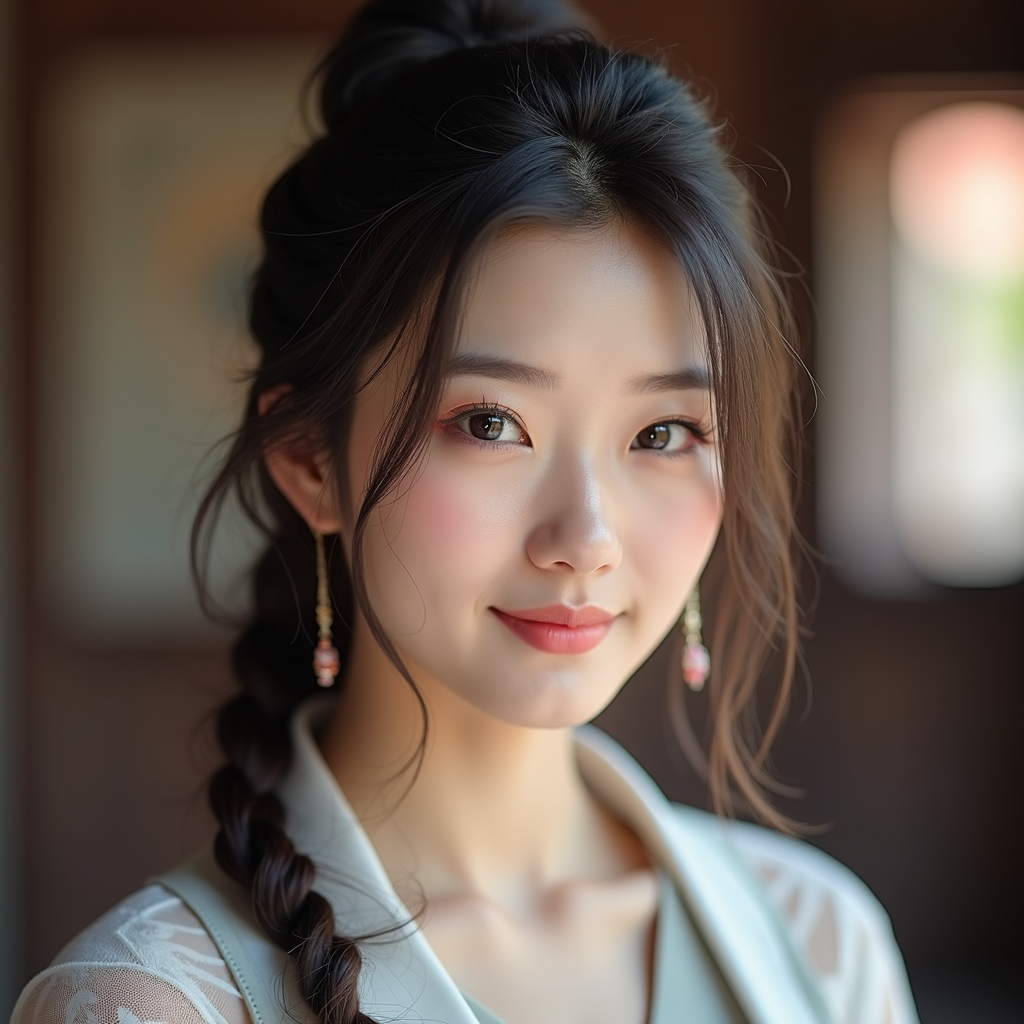

In [3]:
image

In [4]:
latent.shape, latent.flatten().shape

(torch.Size([1, 128, 8, 8]), torch.Size([8192]))

In [5]:
y.shape, y.flatten().shape

(torch.Size([1, 3, 512, 512]), torch.Size([786432]))

In [6]:
def concatenate_images_horizontally(image_paths, output_path):
    images = [Image.open(image_path) for image_path in image_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width

    new_image.save(output_path)
    print(f"Concatenated image saved as {output_path}")


In [7]:
import os

inputs_path, output_path, outputgall_path = "./inputs", "./output", "./output_galleries"
size = 512
transform = transforms.Compose([
    # DMCrop(size), # resolution
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

for input_path in os.listdir(inputs_path):
    if not input_path.endswith(".png"): continue
    input_path = f"{inputs_path}/{input_path}"
    input_fn = os.path.basename(input_path).split(".")[0]

    # crop to 512x512 and save as input
    print(f"reading {input_fn}")
    image = DMCrop(size)(Image.open(input_path).convert("RGB"))
    image.save(f"{output_path}/{input_fn}_input.png")
    x = transform(image)[None].to(device)

    print(f"encoding")
    latent = dc_ae.encode(x)

    print(f"decoding")
    y = dc_ae.decode(latent)
    save_image(y * 0.5 + 0.5, f"{output_path}/{input_fn}_output.png")
    
    concatenate_images_horizontally(
        [f"{output_path}/{input_fn}_input.png", f"{output_path}/{input_fn}_output.png"],
        f"{outputgall_path}/{input_fn}_gallery.png"
    )

reading bafkreicrlzkhyfldaa57g5cutelqakie2yot2mykr7wrabowmam3bznnoq
encoding
decoding
Concatenated image saved as ./output_galleries/bafkreicrlzkhyfldaa57g5cutelqakie2yot2mykr7wrabowmam3bznnoq_gallery.png
reading bafkreihwgl3mrmcvpz2xa6njkv4qjr2yhy3wyniy4r3i3pmvmwnwffbdkq
encoding
decoding
Concatenated image saved as ./output_galleries/bafkreihwgl3mrmcvpz2xa6njkv4qjr2yhy3wyniy4r3i3pmvmwnwffbdkq_gallery.png
reading bafkreied4rpb2ef2r6btzqqrjksfgwaylcpliivpoxy6sfg6xu767qwouq
encoding
decoding
Concatenated image saved as ./output_galleries/bafkreied4rpb2ef2r6btzqqrjksfgwaylcpliivpoxy6sfg6xu767qwouq_gallery.png
reading bafkreiez2thdzw5eti7l7guqdw7mjn63jgebqlxtzsiy2ldqgg3whlbyjm
encoding
decoding
Concatenated image saved as ./output_galleries/bafkreiez2thdzw5eti7l7guqdw7mjn63jgebqlxtzsiy2ldqgg3whlbyjm_gallery.png
reading bafkreieczeyp3ccd3rnt4jsahwlqxvxf4eicsbvzfhg2iwwufmxwl7f7b4
encoding
decoding
Concatenated image saved as ./output_galleries/bafkreieczeyp3ccd3rnt4jsahwlqxvxf4eicsbvzfhg2iw

In [8]:
latent.shape, latent.flatten().shape

(torch.Size([1, 128, 8, 8]), torch.Size([8192]))

In [10]:
y.shape, y.flatten().shape

(torch.Size([1, 3, 512, 512]), torch.Size([786432]))